'서부산 관광지의 마케팅 전략' 프로젝트 정리의 두 번째 시간입니다. 이전 게시글에서는 프로젝트에 대해 소개하고, 리뷰를 크롤링하여 데이터를 수집하는 과정에 대해 작성하였습니다. 이번 게시글에서는 수집한 리뷰 데이터를 본격적으로 분석하는 과정을 정리하려고 합니다. 본 프로젝트에서는 한글로 작성된 리뷰와 영문으로 작성된 리뷰를 비교하는 방식으로 진행하였습니다. 오늘은 그 중에서도 영어 리뷰를 분석한 방법에 대해 글을 작성할 것입니다.\
텍스트 분석은 빈도 분석, 토픽 모델링, Semantic Network Analysis(SNA)를 실시하고, 각각의 카테고리에 따라 서부산과 동부산을 비교하는 방식으로 진행하였습니다. 빈도 분석과 토픽 모델링은 Python을 활용하였고, SNA는 R을 이용하였기때문에, 이번 게시글에서는 빈도 분석과 토픽 모델링에 대해 먼저 다뤄보겠습니다. \
영문 리뷰는 외국인이 많이 방문한 동부산 관광지 5곳에서 수집하였습니다. 5곳에 대해 동일한 방법을 반복하였기에, 저번 게시글과 동일한 방식으로 해동용궁사만을 예시로 글을 작성해보도록 하겠습니다.

In [1]:
import nltk

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/iba_202/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/iba_202/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /home/iba_202/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/iba_202/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

텍스트 분석을 위해서는 위의 데이터를 먼저 다운받아야합니다.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
%matplotlib inline

In [3]:
df = pd.read_csv('Yonggungsa Final.csv')
df.head()

,DATE,RATING,REVIEW,LANGUAGE
0,2020-11-27,5,Haidong Longguang Temple It's really beautiful...,C
1,2019-12-30,5,Pleasant scenery Haidong Longguang Temple is p...,C
2,2019-10-19,5,A beautiful attraction The scenery is very bea...,C
3,2019-09-29,4,"Scenery It is a bit distance from the city, no...",C
4,2019-09-26,3,Solid Buddhist temple with the coast It is a B...,C


# 텍스트 전처리

In [4]:
from bs4 import BeautifulSoup
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import re

## 영어만 남기기

In [5]:
def text_cleaning(t):
    # 영어만 남기기
    t = re.sub('[^a-zA-Z]', ' ', t)
    # 소문자로 변경
    t = t.lower()
    
    return t

리뷰 텍스트에서 영어만 남기기 위한 함수입니다. 문장부호, 특수문자, 숫자 등을 제거하여 영어만 남기고, 대문자는 모두 소문자로 변환합니다.

In [6]:
df['REVIEW'][13]

'Day trip Looking forward to the left good to resist the one-day tour, the first stop, Donghai Longguang Temple, go to the blue sky, white clouds, good ~~ There are many Buddhas to touch, listen to the heart, I want to come true.'

In [7]:
df['REVIEW'] = df['REVIEW'].apply(text_cleaning)
df['REVIEW'][13]

'day trip looking forward to the left good to resist the one day tour  the first stop  donghai longguang temple  go to the blue sky  white clouds  good    there are many buddhas to touch  listen to the heart  i want to come true '

위와 같이 함수가 제대로 적용된 모습입니다.

## 표제어 추출(Lemmatization)

1. 영어만 남기기
2. 표제어 추출(Lemmatization)
3. 불용어 제거, 토큰화(Tokenization)

표제어 추출(Lemmatization)은 다양한 형태로 적힌 단어를 사전형으로 바꿔주는 작업으로, 쉽게 말해 동사를 원형으로 명사의 복수형은 단수로 바꿔주는 등의 작업을 하는 과정입니다. NLTK에서는 표제어 추출을 위해 WordNetLemmatizer을 제공합니다.

In [8]:
def get_wordnet_pos(word):
    # 단어의 품사 태깅
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }

    return tag_dict.get(tag, wordnet.NOUN)

이때 본래 단어의 품사 정보를 입력해야 보다 정확한 결과를 얻을 수 있습니다. 단어의 품사를 태그하는 get_wordnet_pos 함수를 먼저 정의하였습니다. 단어를 입력받아 WordNetLemmatizer에 입력할 품사 태그를 반환합니다.

In [9]:
word = 'leaves'
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize(word, get_wordnet_pos(word)))

leaf


WordNetLemmatizer를 이용하여 표제어를 추출합니다. 복수형 명사를 단수형으로 정확하게 변환하는 것을 확인할 수 있습니다.

In [10]:
def lemmatize_words(t):
    # 각 단어의 품사에 맞게 lemmatize
    lemmatizer = WordNetLemmatizer()
    ret = [
        lemmatizer.lemmatize(word, get_wordnet_pos(word))
        for word in t.split()
    ]
    ret = ' '.join(ret)

    return ret

In [11]:
df['REVIEW'][1]

'pleasant scenery haidong longguang temple is pleasant  the sea is very clear  very beautiful  haidong longguang temple is a guanyin holy land  and the pilgrims come to worship  the traffic is convenient  from haiyuntai station  take bus from haiyun taiwan it is one of busan s necessary visit to the attractions '

In [12]:
df['REVIEW'] = df['REVIEW'].apply(lemmatize_words)

In [13]:
df['REVIEW'][1]

'pleasant scenery haidong longguang temple be pleasant the sea be very clear very beautiful haidong longguang temple be a guanyin holy land and the pilgrim come to worship the traffic be convenient from haiyuntai station take bus from haiyun taiwan it be one of busan s necessary visit to the attraction'

표제어 추출도 완료되어 빈도 분석을 위한 텍스트 전처리가 끝났습니다.

# TF-IDF 빈도분석

이제 TF-IDF를 활용한 빈도분석을 실시하도록 하겠습니다. TF-IDF(Term Frequency-Inverse Document Frequency) Vectorizer는 단순 빈도만을 고려하지 않고, 단어의 빈도와 역 문서 빈도를 곱한 값을 이용해 각 단어의 중요도를 계산하는 방법입니다. 특정 문서에서만 빈도수가 높은 단어들은 중요도가 높지만, 모든 문서에서 빈도수가 높은 단어들은 중요도가 낮다고 간주하여 가중치를 다르게 부여하는 원리입니다.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [15]:
# stopword 정의
sw = stopwords.words('english')
# stopword 추가
sw.extend(['yonggunsa', 'haidong', 'temple', 'longguang', 'must', 'also', 'tem', 'cle', 'really',
          'dragon', 'palace', 'lot', 'many', 'bit'])

In [16]:
# 불용어 제거, 상위 1,000개의 단어 보존
vectorizer = TfidfVectorizer(stop_words=sw, max_features=1000)
tdm = vectorizer.fit_transform(df['REVIEW'])
tdm.shape

(3713, 1000)

이때 의미가 없는 단어를 제거하는 작업이 필요합니다. 접속사, 조동사, 대명사 등 분석에 필요없는 단어를 불용어(Stopword)라고 하며, NLTK에서는 미리 정의한 stopword를 제공하고 있습니다. NLTK에서 기본적으로 제공하는 English Stopword에 새롭게 단어를 추가하여 불용어를 제거하였습니다.

In [17]:
tfidf_weights = [(word, tdm.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]
tfidf_weights[0:5]

[('beautiful', 264.2369421379608),
 ('drive', 10.971925266260811),
 ('far', 35.99537320095098),
 ('away', 20.22409501281627),
 ('bus', 121.39977617033509)]

TF-IDF를 활용한 중요도 계산도 완료되었습니다.

## 워드 클라우드 시각화

중요도 계산 결과를 바탕으로 워드 클라우드를 시각화하였습니다.

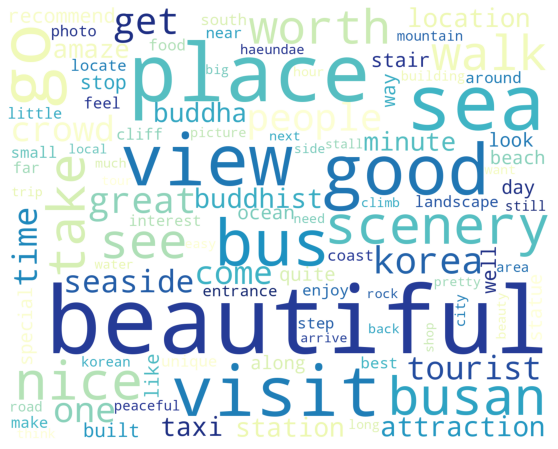

In [18]:
# 상위 100개 단어만 출력
wc = WordCloud(width=1500,
               height=1200,
               background_color='white',
               colormap="YlGnBu",
               max_words=100).fit_words(dict(tfidf_weights))

plt.figure(figsize=(30, 8))
plt.imshow(wc)
plt.axis('off');

위의 사진처럼 워드클라우드가 출력되었습니다. view, beautiful이 가장 먼저 보입니다. 해동용궁사는 경치가 좋은 곳인 것 같습니다. 분석 결과에 대한 자세한 해석은 이번 게시글에서는 하지 않고, 10개 관광지의 분석을 모두 모아 한 번에 진행하도록 하겠습니다.

# LDA Topic Modeling

LDA(Latent Dirichlet Allocation)는 토픽 모델링의 한 방법으로, 주어진 문서를 단어들 간 관련성에 따라 토픽별로 분류하는 알고리즘입니다. 파이썬 내 gensim 패키지를 사용하여 토픽 모델링을 실시하였습니다. 최적의 토픽 개수를 결정하기 위한 지표는 다양하지만, 이번 프로젝트에서는 군집화 결과와 주관적인 판단을 통해 토픽 분류가 가장 잘 이루어지는 토픽 개수로 결정하였습니다.

In [24]:
from gensim import corpora, models
from pprint import pprint

토픽 모델링을 위해 전처리를 조금 더 진행하였습니다. 빈도분석에서 했던 방식과 동일하게 stopword를 제거하고 토큰화 하였습니다.

In [20]:
def remove_stopwords(t):
    # stopword 제거
    ret = [word for word in str(t).split() if word not in sw]
    # 한 글자 이하 단어 제거
    ret = [word for word in ret if len(word)>1]
    
    return ret

1글자로 된 단어의 경우에는 의미가 없는 경우가 많습니다. 따라서 stopword를 제거하면서 동시에 한 글자 단어를 제거하였습니다.

In [21]:
# stopword 정의
sw = stopwords.words('english')
# stopword 추가
sw.extend(['yonggunsa', 'haidong', 'temple', 'longguang', 'must', 'also', 'tem', 'cle', 'really',
          'dragon', 'palace', 'lot', 'many', 'bit'])

# 불용어 제거
tokenized = df['REVIEW'].apply(remove_stopwords)

이제 토픽 모델링을 실시합니다. 토픽 모델링을 하기 전 필터링을 할 수 있는데, 20개 문서 이하에서 등장하거나, 전체 corpus 사이즈에서 0.5 이상 등장하는 단어는 제외하였습니다. 이 조건을 만족하면서 빈도수 기준 상위 100,000개의 토큰만 추출하여 토픽 모델링을 실시하였습니다.

In [22]:
# 정수 인코딩, 빈도수 생성
dictionary = corpora.Dictionary(tokenized)

# 필터링
dictionary.filter_extremes(no_below=20, no_above=0.5, keep_n=100000)

# BoW형태로 벡터화
corpus = [dictionary.doc2bow(text) for text in tokenized]

# 단순 빈도 기반 corpus를 tf-idf로 변환
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# 토픽 모델링
NUM_TOPICS = 5
ldamodel = models.ldamodel.LdaModel(corpus_tfidf,
                                    num_topics=NUM_TOPICS,
                                    id2word=dictionary,
                                    passes=15,
                                    random_state=49,
                                    alpha="auto",
                                    eta="auto")

In [23]:
word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 10)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,go,beautiful,beauty,good,scenery
1,sea,place,rain,peaceful,great
2,beautiful,nice,recommend,place,beautiful
3,bus,landscape,cherry,historical,special
4,take,view,blossom,environment,people
5,visit,korea,scenic,peace,attraction
6,busan,visit,cake,bodhisattva,super
7,see,solemn,sugar,country,place
8,view,amaze,unfortunately,nature,view
9,place,seaside,lovely,full,good


토픽 모델링 결과를 데이터프레임 형태로 저장하였습니다. 토픽 모델링 결과에 대한 해석 역시 다른 게시글에서 한 번에 작성하도록 하겠습니다. 

이러한 방법을 반복하여 동부산 관광지에 대해 작성된 영어 리뷰의 빈도 분석과 토픽 모델링을 완료하였습니다. 다음 게시글에서는 서부산 관광지에 대해 작성된 한글 리뷰에 대한 텍스트 분석에 대해 글을 작성해보도록 하겠습니다. 그럼 이번 게시글은 여기서 마무리하도록 하겠습니다. 오늘도 제 글 읽어주셔서 감사합니다.